# Fetch data

We first import our code module, and fetch the data
The training data and testing data are dictionaries, split into x (data for the neural network) and y (answers to the dataset)

In [1]:
import models

trainData, testData, cols = models.loadData()
trainData["x"].head()

cleaned_dataset.csv


,Home_Team,Away_Team,Season,Round,Elo_home,Elo_away,awayGoal,homeGoal,awayGoalTotal,homeGoalTotal,homeStreak,awayStreak,homeStreakTotal,awayStreakTotal
143935,353,371,2015,31,48.0,53.0,14,23,30,224,1,0,7,2
83074,366,526,1998,23,88.0,69.0,8,68,78,356,1,0,15,3
22291,464,144,1994,5,56.0,62.0,38,86,72,127,2,0,4,4
106266,94,41,2000,41,52.0,53.0,16,94,110,177,0,0,4,5
96129,288,519,2006,27,78.0,86.0,16,15,142,317,0,0,7,5


# Simple model

We load in the simple model, or create one if none is found

In [2]:
sMod = models.loadModel("baseline.joblib")
sMod

LinearRegression()

We then train this model on the data and generate a baseline, then save the model

In [3]:
base = models.trainAndScore(sMod, trainData, testData)
models.saveModel(sMod, "baseline.joblib")

Training model: LinearRegression
Performance summary for LinearRegression
Mean squared error
- Training: 0.6949
- Testing : 0.6949
Score:
- Training:  0.1342
- Testing:   0.1321
- Difference:-0.0021


# Feature selection

We determine the best features in the dataset, save them, and generate a new restricted dataset and score from those

In [4]:
ntrainData, ntestData, ncols, nfeat = models.selectFeatures(trainData, testData, cols, 6)

import numpy as np
np.save("selectedFeatures.npy", ncols)

base2 = models.trainAndScore(sMod, ntrainData, ntestData)

print(f"Selected columns: {', '.join(ncols)}")
ntrainData["x"].head()

Training model: LinearRegression
Performance summary for LinearRegression
Mean squared error
- Training: 0.7945
- Testing : 0.7945
Score:
- Training:  0.0102
- Testing:   0.0092
- Difference:-0.0010
Selected columns: Home_Team, Away_Team, Season, Round, Elo_home, Elo_away


,Away_Team,Elo_away,Elo_home,Home_Team,Round,Season
143935,371,53.0,48.0,353,31,2015
83074,526,69.0,88.0,366,23,1998
22291,144,62.0,56.0,464,5,1994
106266,41,53.0,52.0,94,41,2000
96129,519,86.0,78.0,288,27,2006


# Model selection

We generate a set of new models to test against

In [5]:
mods = models.createNewModels()
f"New models: {', '.join([mod.__class__.__name__ for mod in mods])}"

'New models: LassoLarsIC, LinearDiscriminantAnalysis, SGDClassifier, GaussianNB, DecisionTreeClassifier, BaggingClassifier, MLPClassifier'

We then pit them against eachother, and our baseline model

Training model: LinearRegression
Performance summary for LinearRegression
Mean squared error
- Training: 0.7945
- Testing : 0.7945
Score:
- Training:  0.0102
- Testing:   0.0092
- Difference:-0.0010
Training model: LassoLarsIC
Performance summary for LassoLarsIC
Mean squared error
- Training: 0.7945
- Testing : 0.7945
Score:
- Training:  0.0102
- Testing:   0.0092
- Difference:-0.0010
Training model: LinearDiscriminantAnalysis
Performance summary for LinearDiscriminantAnalysis
Score:
- Training:  0.4816
- Testing:   0.4790
- Difference:-0.0026
Training model: SGDClassifier


/home/skiy/.local/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Performance summary for SGDClassifier
Score:
- Training:  0.4453
- Testing:   0.4443
- Difference:-0.0010
Training model: GaussianNB
Performance summary for GaussianNB
Score:
- Training:  0.4787
- Testing:   0.4786
- Difference:-0.0000
Training model: DecisionTreeClassifier
Performance summary for DecisionTreeClassifier
Score:
- Training:  1.0000
- Testing:   0.4044
- Difference:-0.5956
Training model: BaggingClassifier
Performance summary for BaggingClassifier
Score:
- Training:  0.9845
- Testing:   0.4571
- Difference:-0.5273
Training model: MLPClassifier
Performance summary for MLPClassifier
Score:
- Training:  0.4685
- Testing:   0.4684
- Difference:-0.0001


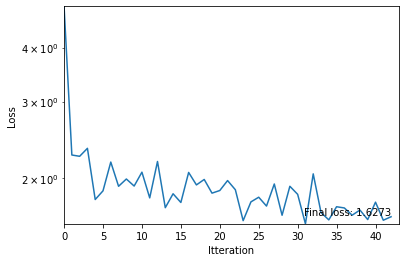

In [6]:
base3 = models.trainAndScore([sMod]+mods, ntrainData, ntestData)

And determine which model performed the best

In [7]:
bestModel = models.scoreModels(base3)

models.saveModel(bestModel, "model.joblib")

LinearDiscriminantAnalysis performed the best on the testing set.


# Itterative training

We then chose to train the model on sub sets of the data that may better represent any newer values
(ie: those games played in more recent years)

In [8]:
strainData = models.subSet(ntrainData, trainData["x"]["Season"] >= 2000)
stestData = models.subSet(ntestData, testData["x"]["Season"] >= 2000)

base4 = models.trainAndScore(bestModel, strainData, stestData)

Training model: LinearDiscriminantAnalysis_best
Performance summary for LinearDiscriminantAnalysis_best
Score:
- Training:  0.4780
- Testing:   0.4732
- Difference:-0.0048
